# Z-Score Normalization

[]

In [12]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies  = pd.read_csv(f'{DATA_PATH}/movies.csv')

#SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101] -> 5개로 감소소
SEED_LIST = [10, 21, 35, 42, 57]
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85

## 1. 전처리 함수 (Z-Score + 최소 평점 필터링)

In [13]:
def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    # 1. 최소 5회 이상 평점 준 사용자만 사용 (페르소나는 강제 포함)
    user_counts = train['userId'].value_counts()
    valid_users = set(user_counts[user_counts >= 5].index)
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    # 2. Train에서만 사용자별 mean / std 계산
    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)   # std=0 방지

    # 3. Z-Score 변환 (Train)
    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    # 4. Test도 동일한 통계량으로 변환 (Train에 없는 사용자는 제거 → cold-start 방지)
    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])   # Train에 없는 사용자 제거
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats   # user_stats도 반환 (역변환에 필요)

## 2. 평가 함수

In [14]:
import numpy as np
import time

def fast_predict_matrix_no_k(train_df):
    """
    K 제한 없이, 유사도가 양수인 모든 아이템을 사용하여 예측
    """
    # 1. Pivot Table 생성 및 R 행렬 정의
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values  # (Users, Items)
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 2. 아이템 간 유사도 행렬 계산
    sim_matrix = np.dot(R.T, R)
    np.fill_diagonal(sim_matrix, -np.inf)
    
    # 3. [핵심 변경] Top-K 필터링 로직 삭제! 양수 유사도만 남김
    S = np.where(sim_matrix > 0, sim_matrix, 0)

    # 4. 예측 평점 계산 (Weighted Sum) -> 분자
    numerator = np.dot(R, S)
    
    # 5. 가중치 합 계산 (Sum of Weights) -> 분모
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    # 6. 나눗셈 (0으로 나누기 방지)
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        pred_z = np.nan_to_num(pred_z)
        
    return pred_z, user_ids, movie_ids

In [15]:
def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

def time_predictions(fn, pairs):
    s = time.perf_counter()
    preds = [fn(u,i) for u,i in pairs]
    e = time.perf_counter() - s
    return preds, e, (e/len(pairs))*1000

## 3. Multi-seed 실험 루프

In [16]:
# ==========================================
# [3. Multi-seed 실험 루프 - K 제한 없음 버전]
# ==========================================

results = []
best_reco = None

print(f"실험 시작: K 제한 없이 모든 양수 유사도 사용. 총 {len(SEED_LIST)}개의 시드 테스트.")

for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    # 1. 데이터 분할 및 전처리
    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    # 2. [핵심] K 제한 없는 행렬 연산으로 모든 예측값 한 번에 계산
    s = time.perf_counter()
    pred_matrix_z, u_ids, m_ids = fast_predict_matrix_no_k(train) # K 파라미터가 사라짐
    e = time.perf_counter() - s
    
    # 인덱싱 맵핑
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    # 3. Test 샘플링 (평가용 데이터 3000개)
    rng = np.random.default_rng(SEED)
    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(n=min(3000, len(test)), random_state=SEED)

    # 4. Test 데이터에 대한 예측값 추출
    z_preds = []
    for uid, mid in zip(test_sample['userId'], test_sample['movieId']):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            z_preds.append(pred_matrix_z[u_idx, m_idx])
        else:
            z_preds.append(0.0)

    # 5. 역변환
    original_preds = []
    for pred_z, row in zip(z_preds, test_sample.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        original_preds.append(pred_z * std_u + mean_u)

    # 6. 결과 저장
    avg_ms = (e / len(test_sample)) * 1000 
    
    res = {
        'seed': SEED,
        'rmse': rmse(test_sample['rating'], original_preds),
        'mae' : mae(test_sample['rating'], original_preds),
        'avg_ms': avg_ms
    }
    results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, Time: {e:.4f}s")

    # 7. 첫 번째 시드(Seed 10)에서만 추천 결과 생성 (로직 동일)
    if idx == 0:
        def recommend(user_id, topk=3):
            if user_id not in u_map: return None
            u_idx = u_map[user_id]
            user_row_preds = pred_matrix_z[u_idx] 
            watched = set(train[train['userId']==user_id]['movieId'])
            
            candidates = []
            for m_idx, m_id in enumerate(m_ids):
                if m_id in watched: continue
                
                z = user_row_preds[m_idx]
                mean_u = user_stats.loc[user_id, 'mean']
                std_u  = user_stats.loc[user_id, 'std']
                final_score = z * std_u + mean_u
                
                candidates.append((m_id, final_score))
            
            candidates.sort(key=lambda x: -x[1])
            top = candidates[:topk]
            
            return [{
                'movieId': m,
                'title': movies.loc[movies['movieId']==m, 'title'].iloc[0] if len(movies.loc[movies['movieId']==m]) > 0 else "Unknown",
                'predicted_rating': round(score, 3)
            } for m, score in top]

        print("\n[추천 결과 생성 중...]")
        best_reco = {
            'heavy': recommend(PERSONA_HEAVY_USER),
            'specialist': recommend(PERSONA_GENRE_SPECIALIST)
        }

print("\n실험 완료! (결과 요약 셀을 실행하세요)")

실험 시작: K 제한 없이 모든 양수 유사도 사용. 총 5개의 시드 테스트.

Running Seed 10 (1/5)
 -> RMSE: 0.8603, Time: 5.0386s

[추천 결과 생성 중...]

Running Seed 21 (2/5)
 -> RMSE: 0.8646, Time: 2.7695s

Running Seed 35 (3/5)
 -> RMSE: 0.8733, Time: 4.9538s

Running Seed 42 (4/5)
 -> RMSE: 0.8896, Time: 5.6644s

Running Seed 57 (5/5)
 -> RMSE: 0.8403, Time: 5.9119s

실험 완료! (결과 요약 셀을 실행하세요)


## 4. 결과 요약

In [17]:
import pandas as pd
df = pd.DataFrame(results)
print(df[['seed','rmse','mae','avg_ms']].round(4))
print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df.rmse.mean():.4f} ± {df.rmse.std():.4f}")
print(f"MAE  : {df.mae.mean():.4f} ± {df.mae.std():.4f}")
print(f"예측 속도 : {df.avg_ms.mean():.2f} ms (± {df.avg_ms.std():.2f})")

print("\n=== 페르소나 추천 결과 (Seed 10) ===")
print(f"헤비 유저 (userId={PERSONA_HEAVY_USER})")
for x in best_reco['heavy']:
    print(f"  → {x['title']}  (예측 평점 {x['predicted_rating']})")

print(f"\n드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST})")
for x in best_reco['specialist']:
    print(f"  → {x['title']}  (예측 평점 {x['predicted_rating']})")

   seed    rmse     mae  avg_ms
0    10  0.8603  0.6483  1.6795
1    21  0.8646  0.6582  0.9232
2    35  0.8733  0.6642  1.6513
3    42  0.8896  0.6718  1.8881
4    57  0.8403  0.6405  1.9706

=== 평균 ± 표준편차 ===
RMSE : 0.8656 ± 0.0181
MAE  : 0.6566 ± 0.0124
예측 속도 : 1.62 ms (± 0.41)

=== 페르소나 추천 결과 (Seed 10) ===
헤비 유저 (userId=414)
  → Harmonists, The (1997)  (예측 평점 5.0)
  → Taxi 3 (2003)  (예측 평점 4.945)
  → The Red Turtle (2016)  (예측 평점 4.804)

드라마 전문가 (userId=85)
  → Mr. Wrong (1996)  (예측 평점 5.0)
  → Before and After (1996)  (예측 평점 5.0)
  → Awfully Big Adventure, An (1995)  (예측 평점 5.0)


## 5. 사용자별 평점 개수 시각화


In [18]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 사용자별 평점 개수 계산
user_rating_counts = ratings.groupby('userId')['rating'].count().reset_index()
user_rating_counts.columns = ['userId', 'rating_count']

print("=== 사용자별 평점 개수 통계 ===")
print(f"전체 사용자 수: {len(user_rating_counts)}")
print(f"평균 평점 개수: {user_rating_counts['rating_count'].mean():.2f}")
print(f"중앙값 평점 개수: {user_rating_counts['rating_count'].median():.2f}")
print(f"최소 평점 개수: {user_rating_counts['rating_count'].min()}")
print(f"최대 평점 개수: {user_rating_counts['rating_count'].max()}")
print(f"표준편차: {user_rating_counts['rating_count'].std():.2f}")
print(f"\n사분위수:")
print(user_rating_counts['rating_count'].describe())

# 페르소나 사용자들의 평점 개수
print(f"\n=== 페르소나 사용자 평점 개수 ===")
persona_counts = user_rating_counts[user_rating_counts['userId'].isin([PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST])]
for _, row in persona_counts.iterrows():
    print(f"사용자 {row['userId']}: {int(row['rating_count'])}개")


=== 사용자별 평점 개수 통계 ===
전체 사용자 수: 610
평균 평점 개수: 165.30
중앙값 평점 개수: 70.50
최소 평점 개수: 20
최대 평점 개수: 2698
표준편차: 269.48

사분위수:
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating_count, dtype: float64

=== 페르소나 사용자 평점 개수 ===
사용자 85: 34개
사용자 414: 2698개


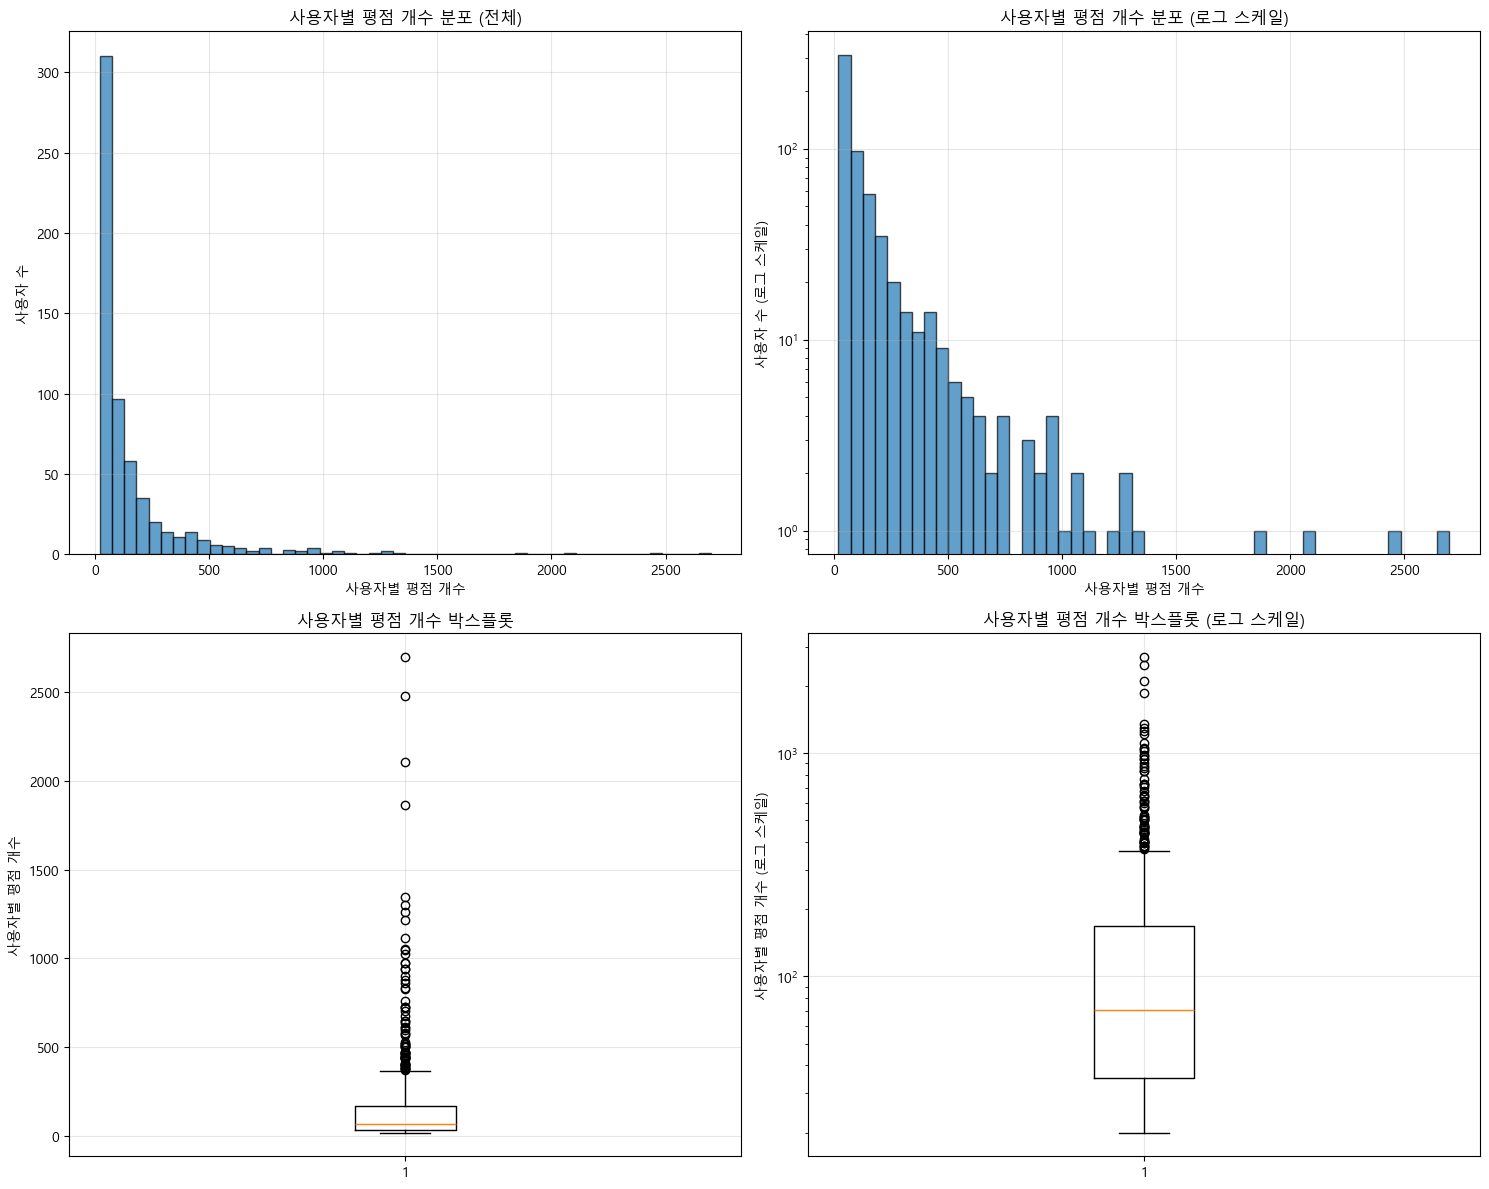

In [19]:
# 시각화 1: 전체 히스토그램
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 전체 히스토그램 (로그 스케일)
axes[0, 0].hist(user_rating_counts['rating_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('사용자별 평점 개수')
axes[0, 0].set_ylabel('사용자 수')
axes[0, 0].set_title('사용자별 평점 개수 분포 (전체)')
axes[0, 0].grid(True, alpha=0.3)

# 2. 로그 스케일 히스토그램
axes[0, 1].hist(user_rating_counts['rating_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('사용자별 평점 개수')
axes[0, 1].set_ylabel('사용자 수 (로그 스케일)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('사용자별 평점 개수 분포 (로그 스케일)')
axes[0, 1].grid(True, alpha=0.3)

# 3. 박스플롯
axes[1, 0].boxplot(user_rating_counts['rating_count'], vert=True)
axes[1, 0].set_ylabel('사용자별 평점 개수')
axes[1, 0].set_title('사용자별 평점 개수 박스플롯')
axes[1, 0].grid(True, alpha=0.3)

# 4. 로그 스케일 박스플롯
axes[1, 1].boxplot(user_rating_counts['rating_count'], vert=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_ylabel('사용자별 평점 개수 (로그 스케일)')
axes[1, 1].set_title('사용자별 평점 개수 박스플롯 (로그 스케일)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


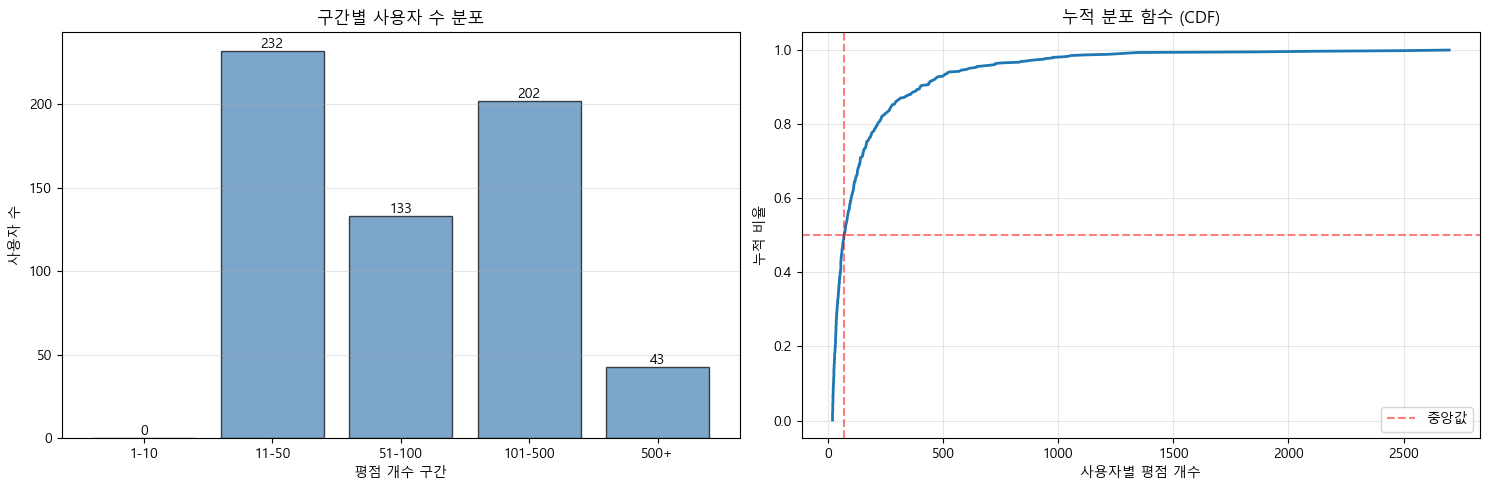

In [20]:
# 시각화 2: 구간별 분포 및 누적 분포
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. 구간별 사용자 수 (0-10, 10-50, 50-100, 100-500, 500+)
bins = [0, 10, 50, 100, 500, float('inf')]
labels = ['1-10', '11-50', '51-100', '101-500', '500+']
user_rating_counts['range'] = pd.cut(user_rating_counts['rating_count'], bins=bins, labels=labels)
range_counts = user_rating_counts['range'].value_counts().sort_index()

axes[0].bar(range_counts.index, range_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('평점 개수 구간')
axes[0].set_ylabel('사용자 수')
axes[0].set_title('구간별 사용자 수 분포')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(range_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# 2. 누적 분포 (CDF)
sorted_counts = np.sort(user_rating_counts['rating_count'])
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
axes[1].plot(sorted_counts, cumulative, linewidth=2)
axes[1].set_xlabel('사용자별 평점 개수')
axes[1].set_ylabel('누적 비율')
axes[1].set_title('누적 분포 함수 (CDF)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='중앙값')
axes[1].axvline(x=user_rating_counts['rating_count'].median(), color='r', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()


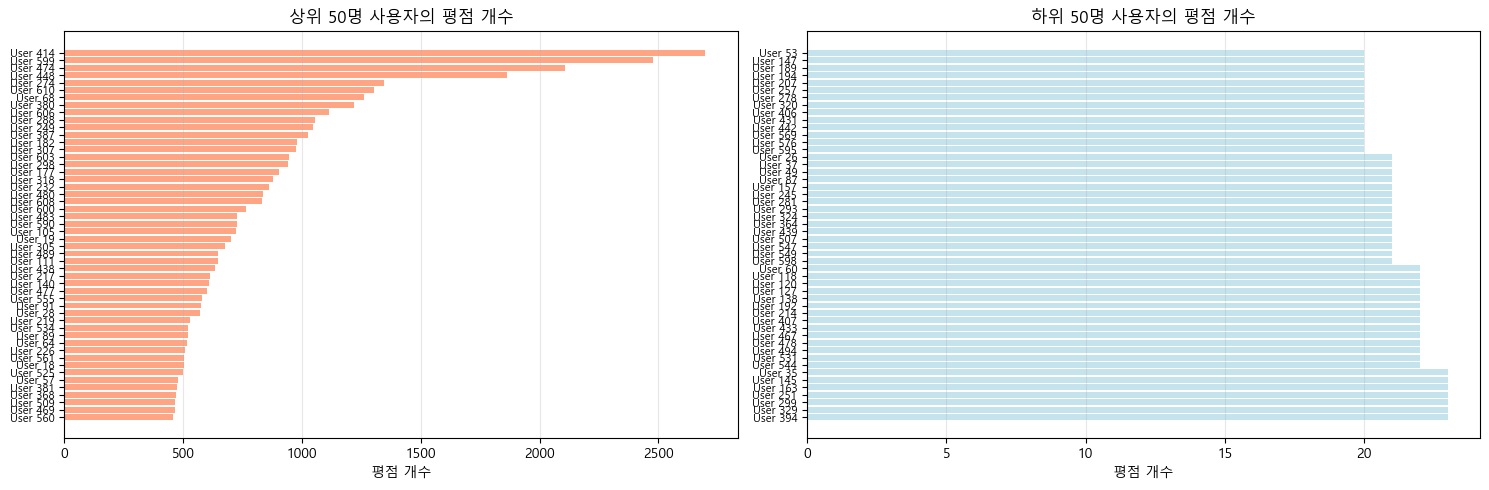

In [21]:
# 시각화 3: 상위/하위 사용자 분석
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 상위 50명 사용자
top_50 = user_rating_counts.nlargest(50, 'rating_count')
axes[0].barh(range(len(top_50)), top_50['rating_count'].values, color='coral', alpha=0.7)
axes[0].set_yticks(range(len(top_50)))
axes[0].set_yticklabels([f"User {uid}" for uid in top_50['userId'].values], fontsize=8)
axes[0].set_xlabel('평점 개수')
axes[0].set_title('상위 50명 사용자의 평점 개수')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# 하위 50명 사용자 (최소 평점 개수)
bottom_50 = user_rating_counts.nsmallest(50, 'rating_count')
axes[1].barh(range(len(bottom_50)), bottom_50['rating_count'].values, color='lightblue', alpha=0.7)
axes[1].set_yticks(range(len(bottom_50)))
axes[1].set_yticklabels([f"User {uid}" for uid in bottom_50['userId'].values], fontsize=8)
axes[1].set_xlabel('평점 개수')
axes[1].set_title('하위 50명 사용자의 평점 개수')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


최소 5회 이상 데이터를 준 사용자를 필터링할 필요가 없음. 한 사용자의 최소 평점 개수가 20개임

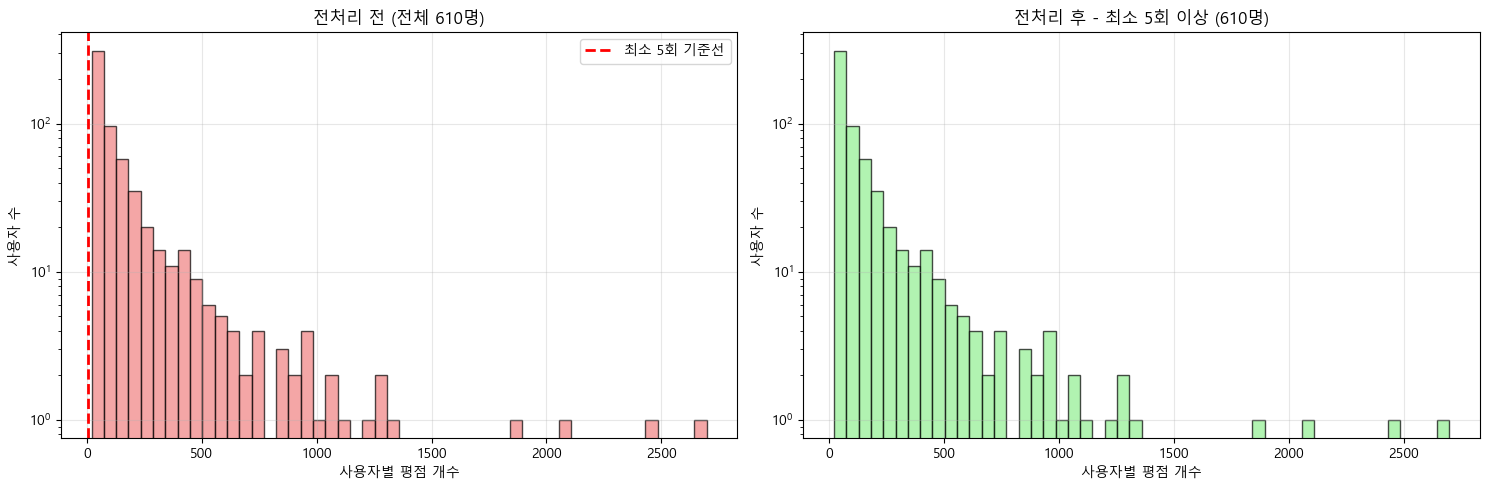


=== 필터링 효과 ===
전처리 전 사용자 수: 610명
전처리 후 사용자 수: 610명
제거된 사용자 수: 0명 (0.0%)


In [22]:
# 시각화 4: 전처리 전후 비교 (최소 5회 이상 필터링 효과)
# 전처리 전
before_filter = ratings.groupby('userId')['rating'].count()
# 전처리 후 (최소 5회 이상)
after_filter = ratings.groupby('userId')['rating'].count()
after_filter = after_filter[after_filter >= 5]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 전처리 전
axes[0].hist(before_filter.values, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0].axvline(x=5, color='r', linestyle='--', linewidth=2, label='최소 5회 기준선')
axes[0].set_xlabel('사용자별 평점 개수')
axes[0].set_ylabel('사용자 수')
axes[0].set_title(f'전처리 전 (전체 {len(before_filter)}명)')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 전처리 후
axes[1].hist(after_filter.values, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('사용자별 평점 개수')
axes[1].set_ylabel('사용자 수')
axes[1].set_title(f'전처리 후 - 최소 5회 이상 ({len(after_filter)}명)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== 필터링 효과 ===")
print(f"전처리 전 사용자 수: {len(before_filter)}명")
print(f"전처리 후 사용자 수: {len(after_filter)}명")
print(f"제거된 사용자 수: {len(before_filter) - len(after_filter)}명 ({100*(len(before_filter) - len(after_filter))/len(before_filter):.1f}%)")
